In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

class HMM:
    def __init__(self):
        self.params = defaultdict(dict)
        self.o2id,self.id2o = dict(),dict()
        self.q2id,self.id2q = dict(),dict()
        self.ct,self.ce = dict(),dict()
    def _setDistinctObservations(self,distO):
        self.o = len(distO)
        for i,o in enumerate(distO):
            self.o2id[o]=i
            self.id2o[i]=o
    def _setDistinctHiddens(self,distQ):
        self.q = len(distQ)
        A = np.random.uniform(0,1,(self.q,self.q))
        A /= np.sum(A,axis=1,keepdims=1)
        B = np.random.uniform(0,1,(self.q,self.o))
        B /= np.sum(B,axis=1,keepdims=1)
        pi = np.random.uniform(0,1,self.q)
        pi/= np.sum(pi)
        self.A = defaultdict(dict)
        self.B = defaultdict(dict)
        self.pi = {}
        for i,q in enumerate(distQ):
            self.q2id[q]=i
            self.id2q[i]=q
            for j,q_ in enumerate(distQ):
                self.A[i][j] = A[i][j]
            for k in range(self.o):
                self.B[i][k] = B[i][k]
            self.pi[i] = pi[i]
    def setDistinctHiddensAndObservations(self,distO,distQ):
        self._setDistinctObservations(distO)
        self._setDistinctHiddens(distQ)
    def setSpecificEmit(self,qSym,emitDict):
        assert round(sum(emitDict.values()))==1, "Sum of probability is not 1"
        for i in self.B[self.q2id[qSym]].keys():
            # assert in dict
            self.B[self.q2id[qSym]][i]=emitDict.get(self.id2o[i],0)
        assert round(sum(self.B[self.q2id[qSym]].values()))==1, "Sum of probability is not 1"
    def setSpecificTransit(self,qSym,tranDict):
        assert round(sum(tranDict.values()))==1, "Sum of probability is not 1"
        for i in self.A[self.q2id[qSym]].keys():
            self.A[self.q2id[qSym]][i]=tranDict.get(self.id2q[i],0)
        assert round(sum(self.A[self.q2id[qSym]].values()))==1, "Sum of probability is not 1"
    def setInitial(self,initDict):
        assert round(sum(initDict.values()))==1, "Sum of probability is not 1"
        for i in self.pi.keys():
            # assert in dict
            self.pi[i]=initDict.get(self.id2q[i],0)
        assert round(sum(self.pi.values()))==1, "Sum of probability is not 1"
    def computeLikelihood(self,Os):
        raise NotImplementedError("You need to implement function1 when you inherit from Model")
    def decode(self,Os):
        raise NotImplementedError("You need to implement function1 when you inherit from Model")
    def learn(self,Qs,Os):
        raise NotImplementedError("You need to implement function1 when you inherit from Model")

In [2]:
def likelihood(self,Os):
    Length = len(Os)
    alpha = np.zeros((self.q,Length))
    for t,o in enumerate(Os):
        for i in range(self.q):
            if t==0:
                alpha[i,t]=self.pi[i]*self.B[i][self.o2id[o]]
            else:
                for j in range(self.q):
                    alpha[i,t]+=alpha[j,t-1]*self.A[j][i]
                alpha[i,t]*=self.B[i][self.o2id[o]]
    return sum(alpha[:,-1]),alpha
def decode(self,Os):
    Length = len(Os)
    V = np.zeros((self.q,Length))
    bt = [0]*Length
    for t,o in enumerate(Os):
        for i in range(self.q):
            if t==0:
                V[i,t]=self.pi[i]*self.B[i][self.o2id[o]]
            else:
                for j in range(self.q):
                    V[i,t]=max(V[i,t],V[j,t-1]*self.A[j][i])
                V[i,t]*=self.B[i][self.o2id[o]]
        bt[t]=self.id2q[np.argmax(V[:,t])]
    P_ = max(V[:,-1])
    return P_,bt
def samples(self,length):
    Qs,Os = [],[]
    for i in range(length):
        if i==0:
            q = np.random.choice(self.q,1,
                    p=list(self.pi.values()))
        else:
            q = np.random.choice(self.q,1,
                    p=list(self.A[q[0]].values()))
        o = np.random.choice(self.o,1,
                    p=list(self.B[q[0]].values()))
        Qs.append(self.id2q[q[0]])
        Os.append(self.id2o[o[0]])
    return Qs,Os
def learn(self,Qs,Os):
    Length = len(Qs)
    if Length==0: return 
    for i,(q,o) in enumerate(zip(Qs,Os)):
        q_ = self.q2id[q]
        o_ = self.o2id[o]
        if i==0:
            self.ct[None]=self.ct.get(None,0)+1
            self.ct[(None,q_)]=self.ct.get((None,q_),0)+1
        if i!=Length-1:
            q_1 = self.q2id[Qs[i+1]]
            self.ct[q_]=self.ct.get(q_,0)+1
            self.ct[(q_,q_1)]=self.ct.get((q_,q_1),0)+1
        self.ce[q_]=self.ce.get(q_,0)+1
        self.ce[(q_,o_)]=self.ce.get((q_,o_),0)+1
    for i in range(self.q):
        self.pi[i]=self.ct.get((None,i),0)/self.ct.get(None,0)
        for j in range(self.q):
            self.A[i][j]=(self.ct.get((i,j),0)+1)/(self.ct.get(i,0)+self.q)
        for o in range(self.o):
            self.B[i][o]=(self.ce.get((i,o),0)+1)/(self.ce.get(i,0)+self.o)
def add_patch(obj):
    obj.computeLikelihood = lambda x:likelihood(obj,x)
    obj.decode = lambda x:decode(obj,x)
    obj.samples = lambda x: samples(obj,x)
    obj.learn = lambda x,y: learn(obj,x,y)
    return obj

In [3]:
def estimateT(s):
    res,total = [],0
    for i,n in enumerate(s):
        total+=1+n
        res.append(total/(i+1))
    return res

#### Markovian Die (Dependent Sampling) vs Die (Independent Sampling)
- Examples of Independent Sampling
    1. Importance Sampling
    2. Inverse Transform
    3. Rejection Sampling
- Examples of Dependent Sampling
    1. Random Walk Metropolis
    2. Metropolis Hastings
    3. HMC
    4. Gibbs Sampling

In [4]:
class experiment:
    def __init__(self):
        self.mu = 3.5
        self._init_markovian_die()
        self._init_die()
    def _init_markovian_die(self):
        mDie = HMM()
        mDie.setDistinctHiddensAndObservations(
            list(range(6)),list(range(6)))
        mDie.setInitial({i:1/6 for i in range(6)})
        mDie = add_patch(mDie)
        for i in range(6):
            if i==0:
                mDie.setSpecificTransit(i,{5:0.5,i+1:0.5})
            elif i==5:
                mDie.setSpecificTransit(i,{i-1:0.5,0:0.5})
            else:
                mDie.setSpecificTransit(i,{i-1:0.5,i+1:0.5})
        self.mDie = mDie
    def _init_die(self):
        die = HMM()
        die.setDistinctHiddensAndObservations(
            list(range(6)),list(range(6)))
        die.setInitial({i:1/6 for i in range(6)})
        die = add_patch(die)
        for i in range(6):
            die.setSpecificTransit(i,{i:1/6 for i in range(6)})
        self.die = die
    def single_experiment_compare_convergence(self,T):
        Qsm,_ = self.mDie.samples(T)
        Qs,_ = self.die.samples(T)
        self.Qsm = Qsm
        self.Qs = Qs
        plt.plot(range(T),estimateT(Qsm),label='Markovian Die')
        plt.plot(range(T),estimateT(Qs),label='Die')
        plt.axhline(y=self.mu,label='Mean',color='r')
        plt.ylabel('Expected Reward')
        plt.xlabel('sample size')
        plt.legend()
    def single_experiment_uniformOrNot(self,Q):
        _ = plt.hist(np.array(Q)+1,bins=6,
                edgecolor='black',linewidth=1.2)
        plt.xlabel('Face Value')
        plt.ylabel('Count')
    def multiple_experiments_errorHist(self,sampler,T=100,
                iters=1000,plot=False):
        mm,me = [],0
        for i in tqdm(range(iters)):
            Q,_ = sampler.samples(T)
            dif = np.array(estimateT(Q))-self.mu
            m = np.mean(dif)
            me+=dif**2
            mm.append(m)
        me = np.sqrt(me/iters)
        self.me,self.mm = me,mm
        if plot:
            _ = plt.hist(mm,bins=25,edgecolor='black',linewidth=1.2)
            plt.xlabel('Error')
            plt.ylabel('Count')
    def multiple_experiments_effective_sample_size(self,
                T=100,iters=1000):
        self.multiple_experiments_errorHist(self.mDie,T,iters)
        mem = self.me
        self.multiple_experiments_errorHist(self.die,T,iters)
        me = self.me
        plt.plot(range(T),mem,label='Dependent')
        plt.plot(range(T),me,label='Independent')
        plt.xlabel('sample size')
        plt.ylabel('average error (RMSE)')
        plt.legend()

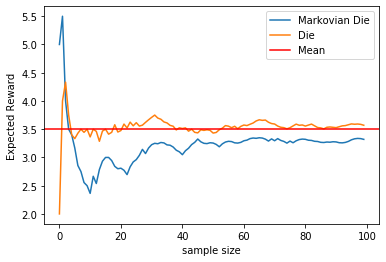

In [5]:
e = experiment()
e.single_experiment_compare_convergence(100)

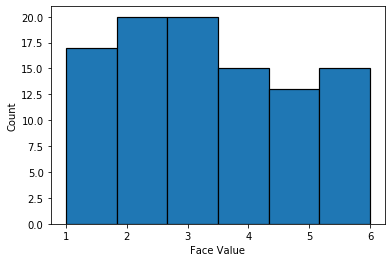

In [6]:
e.single_experiment_uniformOrNot(e.Qsm)

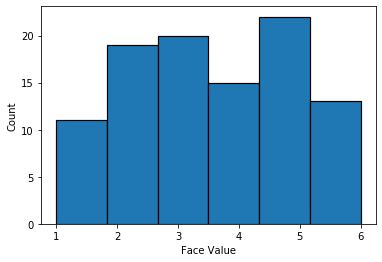

In [7]:
e.single_experiment_uniformOrNot(e.Qs)

100%|██████████| 1000/1000 [00:03<00:00, 308.32it/s]


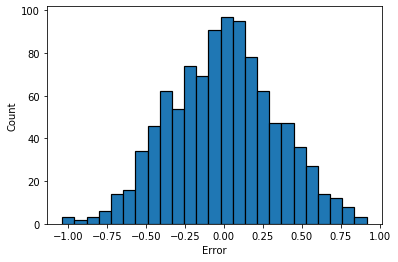

In [8]:
e.multiple_experiments_errorHist(e.mDie,T=100,iters=1000,plot=True)

100%|██████████| 1000/1000 [00:03<00:00, 300.76it/s]


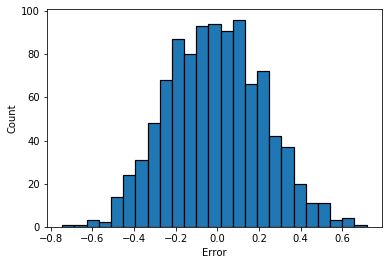

In [9]:
e.multiple_experiments_errorHist(e.die,T=100,iters=1000,plot=True)

100%|██████████| 1000/1000 [00:03<00:00, 308.34it/s]


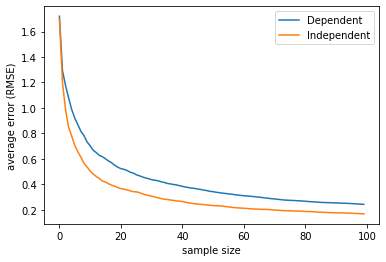

In [10]:
e.multiple_experiments_effective_sample_size()

**Effective Sample Size** is defined as follows,
$$ESS = \frac{mT}{1+\sum_{J=1}^{T'}\hat{\rho}_J}$$

where m total sample size, T sample size for each markov chain, $\hat{\rho}$ autocorrelation which the slope between $\theta_t$ and $\{\theta\}_{0}^{t-1}$.

1. I guess, markovian die has $\rho=2$ and die has $\rho=6$, so die has better effective sample size. 
2. The higher the autocorrelation is, the lower the ESS.